# Clustering Crypto

In [687]:
# NOTE: Launch with increased data rate to allow API to retrieve data:
# jupyter lab --NotebookApp.iopub_data_rate_limit=100000000000

# Initial imports
import requests, json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Fetching Cryptocurrency Data

In [688]:
# Use the following endpoint to fetch json data
url = "https://min-api.cryptocompare.com/data/all/coinlist"

In [689]:
# Create a DataFrame
# json_data = requests.get(url).json()
# print(json.dumps(json_data["Data"], indent=4))
# crypto_df = pd.json_normalize(json["Data"])
# crypto_df
# crypto_df = crypto_df.T


In [690]:
# Alternatively, use the provided csv file:
file_path = Path("Resources/crypto_data.csv")

# Create a DataFrame
crypto_df = pd.read_csv(file_path)
crypto_df

,Unnamed: 0,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,611,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,808,SHA-256,True,PoW/PoS,0.000000e+00,0
...,...,...,...,...,...,...,...
1247,XBC,BitcoinPlus,Scrypt,True,PoS,1.283270e+05,1000000
1248,DVTC,DivotyCoin,Scrypt,False,PoW/PoS,2.149121e+07,100000000
1249,GIOT,Giotto Coin,Scrypt,False,PoW/PoS,NaN,233100000
1250,OPSC,OpenSourceCoin,SHA-256,False,PoW/PoS,NaN,21000000


### Data Preprocessing

In [691]:
# Keep only necessary columns:
crypto_df.columns = [ "CoinNumber", "CoinName", "Algorithm", "IsTrading", "ProofType", "TotalCoinsMined", "TotalCoinSupply" ]
crypto_df.drop(columns=[ "CoinNumber" ], inplace=True)
# crypto_df = crypto_df.set_index("CoinNumber")
crypto_df


,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
0,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
1,365Coin,X11,True,PoW/PoS,NaN,2300000000
2,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
3,SixEleven,SHA-256,True,PoW,NaN,611000
4,808,SHA-256,True,PoW/PoS,0.000000e+00,0
...,...,...,...,...,...,...
1247,BitcoinPlus,Scrypt,True,PoS,1.283270e+05,1000000
1248,DivotyCoin,Scrypt,False,PoW/PoS,2.149121e+07,100000000
1249,Giotto Coin,Scrypt,False,PoW/PoS,NaN,233100000
1250,OpenSourceCoin,SHA-256,False,PoW/PoS,NaN,21000000


In [692]:
# Keep only cryptocurrencies that are trading
crypto_df = crypto_df[crypto_df["IsTrading"] == True]
crypto_df.shape


(1144, 6)

In [693]:
# Keep only cryptocurrencies with a working algorithm
# crypto_df = crypto_df[crypto_df["?"] == True]
# crypto_df.shape


In [694]:
# Remove the "IsTrading" column
crypto_df = crypto_df.drop(columns=[ "IsTrading" ])
crypto_df.shape


(1144, 5)

In [695]:
# Remove rows with at least 1 null value
crypto_df = crypto_df.dropna()
crypto_df.shape


(685, 5)

In [696]:
# Remove rows with cryptocurrencies having no coins mined
crypto_df = crypto_df[crypto_df["TotalCoinsMined"] > 0]
crypto_df.shape


(532, 5)

In [697]:
crypto_df.columns

Index(['CoinName', 'Algorithm', 'ProofType', 'TotalCoinsMined',
       'TotalCoinSupply'],
      dtype='object')

In [698]:
# Drop rows where there are 'N/A' text values
# TODO
# crypto_df = 
# crypto_df[crypto_df[:] == "N/A"]
# crypto_df["TotalCoinSupply"].str.replace('NaN', '0')
# crypto_df.shape


In [699]:
# Store the 'CoinName' column in its own DataFrame prior to dropping it from crypto_df
coin_name_column = crypto_df["CoinName"]


In [700]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
crypto_df = crypto_df.drop(columns=["CoinName"])
crypto_df.shape


(532, 4)

In [701]:
# Create dummy variables for text features
# X = df.loc[:, ["Algorithm", "ProofType", "TotalCoinSupply" ]]
# y = df["TotalCoinsMined"]

crypto_df_dummies = pd.get_dummies(crypto_df, columns = ["Algorithm", "ProofType"])
crypto_df_dummies


,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
0,4.199995e+01,42,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,1.792718e+07,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1.076842e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1238,2.000000e+09,2000000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1242,1.493105e+07,250000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1245,9.802226e+08,1400222610,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1246,7.296538e+06,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [702]:
# Standardize data
crypto_df_dummies = StandardScaler().fit_transform(crypto_df_dummies)
print(crypto_df_dummies[0:1])


[[-0.11710817 -0.1528703  -0.0433963  -0.0433963  -0.0433963  -0.06142951
  -0.07530656 -0.0433963  -0.06142951 -0.06142951 -0.0433963  -0.0433963
  -0.19245009 -0.06142951 -0.09740465 -0.0433963  -0.11547005 -0.07530656
  -0.0433963  -0.0433963  -0.15191091 -0.0433963  -0.13118084 -0.0433963
  -0.0433963  -0.08703883 -0.0433963  -0.0433963  -0.0433963  -0.0433963
  -0.06142951 -0.0433963  -0.08703883 -0.08703883 -0.08703883 -0.0433963
  -0.13118084 -0.13840913 -0.13840913 -0.0433963  -0.06142951 -0.0433963
  -0.07530656 -0.18168574 -0.0433963  -0.0433963  -0.0433963  -0.07530656
  -0.15826614 -0.31491833 -0.0433963  -0.08703883 -0.07530656 -0.06142951
   1.38675049 -0.0433963  -0.0433963  -0.06142951 -0.0433963  -0.0433963
  -0.0433963  -0.0433963  -0.0433963  -0.0433963  -0.0433963  -0.0433963
  -0.39879994 -0.0433963  -0.18168574 -0.0433963  -0.08703883 -0.08703883
  -0.10680283 -0.0433963  -0.13118084 -0.0433963  -0.0433963  -0.0433963
  -0.0433963  -0.07530656 -0.43911856 -0.04339

### Reducing Dimensions Using PCA

In [703]:
# Use PCA to reduce dimensions to 3 principal components
pca = PCA(n_components=3)
crypto_pca = pca.fit_transform(crypto_df_dummies)


In [704]:
# Create a DataFrame with the principal components data
crypto_pca_df = pd.DataFrame(data=crypto_pca, columns=["PC1", "PC2", "PC3"])
crypto_pca_df


,PC1,PC2,PC3
0,-0.339911,1.019732,-0.582783
1,-0.323214,1.020045,-0.583204
2,2.317995,1.671879,-0.624135
3,-0.143326,-1.317977,0.202067
4,-0.145086,-2.104744,0.385004
...,...,...,...
527,2.445221,0.696396,-0.044373
528,-0.337951,1.019640,-0.582812
529,0.336653,-2.278057,0.414114
530,-0.149081,-2.041689,0.465257


### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [705]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(crypto_pca_df)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")


:Curve   [k]   (inertia)

Running K-Means with `k=<your best value for k here>`

In [706]:
# Initialize the K-Means model
model = KMeans(n_clusters=4, random_state=0)

# Fit the model
model.fit(crypto_pca_df)

# Predict clusters
predictions = model.predict(crypto_pca_df)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
# crypto_cluster_results = pd.DataFrame({"ClusterLabels": model.labels_, "Predictions": predictions})

# crypto_cluster_results = crypto_df.copy()
# crypto_cluster_results["PC1"] = crypto_pca_df["PC1"]
# crypto_cluster_results["PC2"] = crypto_pca_df["PC2"]
# crypto_cluster_results["PC3"] = crypto_pca_df["PC3"]
# crypto_cluster_results

# model.labels_
# pd.DataFrame({"ClusterLabels": model.cluster_centers_})
# predictions

crypto_df = crypto_df.reset_index()
crypto_pca_df = crypto_pca_df.reset_index()
# coin_name_column = coin_name_column.reset_index()

clustered_df = crypto_df.loc[:, [ "Algorithm", "ProofType", "TotalCoinsMined", "TotalCoinSupply" ]]
clustered_df["PC1"] = crypto_pca_df["PC1"]
clustered_df["PC2"] = crypto_pca_df["PC2"]
clustered_df["PC3"] = crypto_pca_df["PC3"]
clustered_df["CoinName"] = coin_name_column
clustered_df["Class"] = model.labels_
clustered_df


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC1,PC2,PC3,CoinName,Class
0,Scrypt,PoW/PoS,4.199995e+01,42,-0.339911,1.019732,-0.582783,42 Coin,1
1,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.323214,1.020045,-0.583204,NaN,1
2,X13,PoW/PoS,2.927942e+10,314159265359,2.317995,1.671879,-0.624135,404Coin,1
3,SHA-256,PoW,1.792718e+07,21000000,-0.143326,-1.317977,0.202067,NaN,0
4,Ethash,PoW,1.076842e+08,0,-0.145086,-2.104744,0.385004,NaN,0
...,...,...,...,...,...,...,...,...,...
527,SHA-256,DPoS,2.000000e+09,2000000000,2.445221,0.696396,-0.044373,NaN,1
528,Scrypt,PoW/PoS,1.493105e+07,250000000,-0.337951,1.019640,-0.582812,NaN,1
529,CryptoNight,PoW,9.802226e+08,1400222610,0.336653,-2.278057,0.414114,NaN,0
530,Equihash,PoW,7.296538e+06,21000000,-0.149081,-2.041689,0.465257,NaN,0


In [707]:
crypto_pca_df
crypto_df

,index,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
0,0,Scrypt,PoW/PoS,4.199995e+01,42
1,2,Scrypt,PoW/PoS,1.055185e+09,532000000
2,5,X13,PoW/PoS,2.927942e+10,314159265359
3,7,SHA-256,PoW,1.792718e+07,21000000
4,8,Ethash,PoW,1.076842e+08,0
...,...,...,...,...,...
527,1238,SHA-256,DPoS,2.000000e+09,2000000000
528,1242,Scrypt,PoW/PoS,1.493105e+07,250000000
529,1245,CryptoNight,PoW,9.802226e+08,1400222610
530,1246,Equihash,PoW,7.296538e+06,21000000


In [708]:
clustered_df["Class"].nunique()


4

### Visualizing Results

#### 3D-Scatter with Clusters

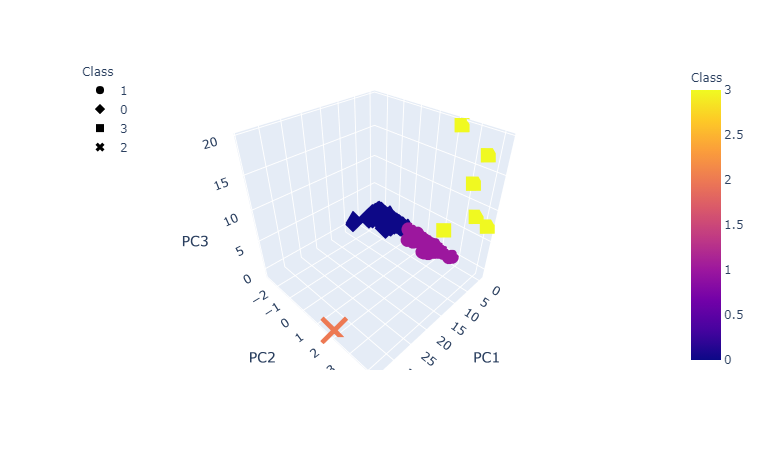

In [709]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(clustered_df, x="PC1", y="PC2", z="PC3", color="Class", symbol="Class", width=800)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()


#### Table of Tradable Cryptocurrencies

In [710]:
# Table with tradable cryptos
clustered_df


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC1,PC2,PC3,CoinName,Class
0,Scrypt,PoW/PoS,4.199995e+01,42,-0.339911,1.019732,-0.582783,42 Coin,1
1,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.323214,1.020045,-0.583204,NaN,1
2,X13,PoW/PoS,2.927942e+10,314159265359,2.317995,1.671879,-0.624135,404Coin,1
3,SHA-256,PoW,1.792718e+07,21000000,-0.143326,-1.317977,0.202067,NaN,0
4,Ethash,PoW,1.076842e+08,0,-0.145086,-2.104744,0.385004,NaN,0
...,...,...,...,...,...,...,...,...,...
527,SHA-256,DPoS,2.000000e+09,2000000000,2.445221,0.696396,-0.044373,NaN,1
528,Scrypt,PoW/PoS,1.493105e+07,250000000,-0.337951,1.019640,-0.582812,NaN,1
529,CryptoNight,PoW,9.802226e+08,1400222610,0.336653,-2.278057,0.414114,NaN,0
530,Equihash,PoW,7.296538e+06,21000000,-0.149081,-2.041689,0.465257,NaN,0


In [711]:
# Print the total number of tradable cryptocurrencies
clustered_df.shape[0]


532

#### Scatter Plot with Tradable Cryptocurrencies

In [712]:
# Scale data to create the scatter plot


In [713]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
